# Project Assignment

This project looks at the character network of the very popular series Game of Thrones. This report goes over the steps taken to create the network as well as some analysis made to further explore the network. Each character will be represented as a node in the network and references to other characters from each character's page will be the links between nodes in the network.

Before we begin, let's start off by importing all necessary libraries that will be used in this report.

In [1]:
import random
import os
import urllib
import re
import networkx as nx
import os
from urllib.request import Request, urlopen
import numpy as np
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import pandas as pd
import math
from wordcloud import WordCloud, STOPWORDS
import imageio
import csv
import community as community_louvain
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Creating the network

To begin data extraction the first thing to do is to extract a list of all the Game of Thrones characters. The list of characters was found on [this](https://awoiaf.westeros.org/index.php/List_of_characters) website and stored in an array called *all_characters*.

**RegEx explanation:**

Two regex patterns were used when extracting character names from this website. 
* **pattern_1**: `(?:===A===)(.*?)(?:\[\[Category\:Characters\| \]\])` finds everything between `===A===` and `[[Category:Characters| ]]`. This extracts all character names, and everything in between, from the site and stores in a single string variable. To isolate the individual characters the string was split up into parts based on linebreaks and each part saved in a list called *characters*

* **pattern_2**: `(?:\[\[)(.*?)(?:\]\]|\|.*?)` is used on each line in the *characters* list to further isolate the character name only. This regex pattern matches text between two square brackets `[[]]`. If the text in the square brackets is split into two using a vertical line `|` then the text on the right side is matched. 


In [2]:
baseurl = 'https://awoiaf.westeros.org/api.php?'
action = 'action=query'
title = 'titles=List_of_characters'
content='prop=revisions&rvprop=content&rvslots=*'
dataformat='format=json'

query = '%s&%s&%s&%s&%s' % (baseurl,action,title,content,dataformat)

req = Request(query, headers = {'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req, timeout=10).read().decode('utf-8')

pattern_1 = "(?:===A===)(.*?)(?:\[\[Category\:Characters\| \]\])"
characters = re.findall(pattern_1,webpage)
characters = characters[0].split('\\n*')

pattern_2 = "(?:\[\[)(.*?)(?:\]\]|\|.*?)"
all_characters = []
for c in characters:
    match = re.findall(pattern_2, c)
    if match:
        all_characters.append(match[0])

In [3]:
print("Number of characters extracted from 'awoiaf.westeros.org': ",len(all_characters))

Number of characters extracted from 'awoiaf.westeros.org':  3669


Next up is finding the character pages available on the information [website](https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki) and saving as txt files in a directory called *GoT_characters*.

In [4]:
baseurl = 'https://gameofthrones.fandom.com/api.php?'
action = 'action=query'
content='prop=revisions&rvprop=content&rvslots=*'
dataformat='format=json'
characters_path = './GoT_characters/'

In [5]:
# This function will be used to extract a character page's html
def getHtml(name):
    new_name = name.replace(' ','_')
    parsed_name = urllib.parse.quote_plus(new_name)
    title = 'titles='+parsed_name
    query = '%s&%s&%s&%s&%s' % (baseurl,action,title,content,dataformat)
    response = urllib.request.urlopen(query)
    html = response.read().decode('utf-8')
    return html, new_name

The code here below was used to extract character pages and saving as txt files. This is commented out for your benefit as the `.txt` files are already downloaded and saved in the `GoT_characters` directory.

**RegEx explanation:**

Three regex patterns were used to filter out unwanted data and making sure to match the correct data in the character pages.
* **filter_pattern**: `(?:== *Biography *==)(.*?)(?:== *See also *==)` was used to filter on only characters whose character pages were on the correct format, i.e starting with a `Biography` header and ending with a `See also` header.
* **fail_pattern**: `\",\"missing\":\"\"\}\}\}\}` was used to exclude character pages where the url opened a page that did not exist (Page Not Found). This pattern was used to search the page text and if matched the page would not be saved. The pattern matches a text on this format `","missing":""}}}}`.
* **redirect_pattern**: `(?:#REDIRECT *\[\[)(.*?)(?:\]\])` was used to make sure that when a character page redirected to another page the text on the redirected page would be used. An example of a redirect is for example the character Ned Stark. If the page is retrieved using the name Ned Stark the page will redirect to a page under the name of Eddard Stark, which is his actual name. To check wheather a page was a redirect, the page was searched for the subtext `#REDIRECT` and if a match was found a new html for the redirected page would be fetched. The redirect pattern fetches the name of the redirected character by matching anything between `#REDIRECT *[[` and `]]`.

In [6]:
filter_pattern = "(?:== *Biography *==)(.*?)(?:== *See also *==)"
fail_pattern = '\",\"missing\":\"\"\}\}\}\}'
redirect_pattern = '(?:#REDIRECT *\[\[)(.*?)(?:\]\])'

In [7]:
_ = """
for c in all_characters:
    print(c)
    html, new_name = getHtml(c)
    if not re.search(fail_pattern,html) and not re.search('can refer to:',html):   
        if re.search('#REDIRECT',html):
            redirect_name = re.findall(redirect_pattern,html)
            html, new_name = getHtml(redirect_name[0])
        if re.search(filter_pattern,html):
            file_name = new_name + '.txt'
            text_file = open(characters_path+file_name, "w")
            text_file.write(html)
            text_file.close()  
"""

For the next part in the analysis, a list of all characters used is required. To get that list of charcters, a list of the names of all the files in the GoT_characters directory was extracted. The characters' names were found by removing the `.txt` and the `_` from the file names. All hidden files were skipped.

In [8]:
#All usable character names to a list
characters = []
arr = os.listdir('./GoT_characters')
for file in arr:
    if not file.startswith('.'):
        name = file.replace('_',' ')
        name = name.replace('.txt','')
        characters.append(name)

In [9]:
#Creating a graph and adding all characters as nodes
G = nx.DiGraph()
G.add_nodes_from(characters)

Next up is fetching some attributes from the character pages and assigning to each node. The attributes chosen to retrieve in this assignment were `Status` which stores information wheather a character is alive or deceased, `Allegiance` which has information regarding which house a character is allegiant to, and the `Death` attribute stores information on how a character died.

**RegEx explanation:**

Multiple regex patterns were used to fetch the attribute information from the character pages. For many of the attributes the regex matching was done in two steps, using a custom pattern for the attribute as the first step while the second step used the same pattern for all attributes. A few attributes only had one custom step.

* **pattern_status**: `(?:Status *= *\[\[.*?\|)(.*?)(?:\]\])` extracts the status of the character by matching everything between `Status = [[*some text*|` (where spaces around the equal signs could also be omitted) and `]]`.
* **pattern1_allegiance**: `(?:Allegiance *= *)(.*?)(?:\\\\n)` was used to extract the line which has information on which house, or group, the character was allegiant to. This pattern matches everything between `Allegiance = ` (where the spaces can be omitted) and a new line `\\n`.
* **pattern1_mother**: `(?:Mother *= *)(.*?)(?:\\\\n)` finds the line which contains information about the character's mother by matching everything between `Mother = ` (where the spaces can be omitted) and a new line `\\n`.
* **pattern1_father**: `(?:Father *= *)(.*?)(?:\\\\n)` finds the line which contains information about the character's father by matching everything between `Father = ` (where the spaces can be omitted) and a new line `\\n`.
* **pattern1_siblings**: `(?:Siblings *= *)(.*?)(?:\\\\n\||\{\{Quote)` finds the line which contains information about the character's siblings by matching everything between `Siblings = ` (where the spaces can be omitted) and `\\n|` or `{{Quote`.
* **pattern1_children**: `(?:Children *= *)(.*?)(?:\\\\n\||\|Titles|\\\\n\})` finds line which contains information about the character's children by matching everything between `Children = ` (where the spaces can be omitted) and `\\n|` or `|Titles` or `\\n}`.
* **pattern1_spouse**: `(?:Spouse *= *)(.*?)(?:\\\\n\||\-\-\>\||\{\{Quote|\]\]\}\||\\\\n\})` finds line which contains information about the character's spouse by matching everything between `Spouse = ` (where the spaces can be omitted) and `\\n|` or `-->|` or `\\n}`.
* **pattern2**: `(?:\{*\[\[)(.*?)(?:\]\]\}*|\|.*?\]\])` this is the second pattern used to extract the actual information from the information lines we have already extracted. This pattern extracts all links in the line by matching everything between `{[[` (where the curly bracket can be omitted) and `]]}` (where the curly bracket can be omitted) or `|*some text*]]`
* **pattern_death**: `(?:Death *= *)(.*?)(?:\\\\n\|)` is the first of four different patterns used to extract the information on how the character died. This pattern fetches the line that stores the death information by matching everything between `Death = ` (where the spaces can be omitted) and `\\n|)`.
* **pattern_death1**: `(?:on the orders (?:of )*(?:King )*)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])` this pattern is the second death pattern used. This is used to match everything between `on the orders of King [[*some text*]] [[` and `|*some text*]]`. However, a lot of this can be omitted. `of` and `King` can be omitted as well as the `[[*some text*]] ` in the pattern before the match. In the pattern after the match the `|*some text*` before the closing brackets can be omitted.
* **pattern_death2**: `(?:by *)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])` this pattern was used to extract death information where the formatting was different than the one above. In this pattern, everything between `by [[*some text*]] [[` and `|*some text*]]` was matched. Here the `[[*some text*]] ` in the pattern before the match can be omitted and the `|*some text*` in the pattern after can be as well.
* **pattern_death3**: `(?:by *)([\(\)\'a-zA-Z\s\d]*)(?:\]\])` the last death pattern matches everything between `by ` and `]]` where the space following `by` can be omitted.

In [10]:
#Initializing regex patterns
pattern_status = "(?:Status *= *\[\[.*?\|)(.*?)(?:\]\])"
pattern1_allegiance = '(?:Allegiance *= *)(.*?)(?:\\\\n)'
pattern1_mother = '(?:Mother *= *)(.*?)(?:\\\\n)'
pattern1_father = '(?:Father *= *)(.*?)(?:\\\\n)'
pattern1_siblings = '(?:Siblings *= *)(.*?)(?:\\\\n\||\{\{Quote)'
pattern1_children = '(?:Children *= *)(.*?)(?:\\\\n\||\|Titles|\\\\n\})'
pattern1_spouse = '(?:Spouse *= *)(.*?)(?:\\\\n\||\-\-\>\||\{\{Quote|\]\]\}\||\\\\n\})'
pattern2 = '(?:\{*\[\[)(.*?)(?:\]\]\}*|\|.*?\]\])'
pattern_death = '(?:Death *= *)(.*?)(?:\\\\n\|)'

#Fetching all character pages
for node in G.nodes():
    new_name = node.replace(' ','_')
    with open('./GoT_characters/'+new_name+'.txt') as f:
        text = f.read()
        f.close() 
    
    #Finding status of character. If no match is found status is Unknown
    status = re.findall(pattern_status, text)
    if not status or not status[0]:
        status = ['Uncertain']

    #Creating array to store death information
    death = []   
    #Fetching the line which stores the death information from the character page
    temp_death = re.findall(pattern_death,text)
    #Cause of death is found from temp_death using the three different death patterns. If no match is found, death is set to Unknown
    if temp_death:
        pattern_death1 = "(?:on the orders (?:of )*(?:King )*)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])"
        new_temp_death1 = re.findall(pattern_death1,temp_death[0])
        pattern_death2 = "(?:by *)(?:(?:\[\[.*?\]\])* *\[\[)([\(\)\'a-zA-Z\s\d]*)(?:(?:\|.*?)*\]\])"
        new_temp_death2 = re.findall(pattern_death2,temp_death[0])
        pattern_death3 = "(?:by *)([\(\)\'a-zA-Z\s\d]*)(?:\]\])"
        new_temp_death3 = re.findall(pattern_death3,temp_death[0])
        temp_death = new_temp_death1 + new_temp_death2 + new_temp_death3
        if temp_death:
            death.append(temp_death[0])
        else:
            death = ['Unknown']
    else:
        death = ['Unknown']   
    if death[0] not in characters:
        death = ['Unknown']
     
    #Fetching the line which stores the allegiance information from the character page
    temp_allegiance = re.findall(pattern1_allegiance, text)
    #Allegiance information is extracted from temp_allegiance. If no match is found, allegiance is set to 'Uncertain'
    if temp_allegiance:
        allegiance = re.findall(pattern2,temp_allegiance[0])
    else:
        allegiance = ['Uncertain']

    #Fetching the line which stores the family information from the character page
    #If no matches are found, relevant attributes are set to Unknown
    temp_mother = re.findall(pattern1_mother, text)
    if temp_mother:
        mother = re.findall(pattern2,temp_mother[0])
    else:
        mother = ['Unkown']

    temp_father = re.findall(pattern1_father, text)
    if temp_father:
        father = re.findall(pattern2,temp_father[0])
    else:
        father = ['Unkown']

    temp_spouse = re.findall(pattern1_spouse,text)
    
    #Edge case for a character named Harlen Tyrell eliminated
    if node == 'Harlen Tyrell':
        spouse = ['Unknown']
    elif temp_spouse:
        spouse = re.findall(pattern2,temp_spouse[0])
        if not spouse:
            spouse = ['Unknown']
    else:
        spouse = ['Unknown']

    temp_siblings = re.findall(pattern1_siblings,text)
    if temp_siblings:
        siblings = re.findall(pattern2,temp_siblings[0])
    else:
        siblings = ['Unknown']

    temp_children = re.findall(pattern1_children,text)
    if temp_children:
        #sometimes the extracted line containing the children information also has information on who the character had the child with
        #that info is removed using re.sub so that is not included in the children list
        temp_children = re.sub(' by \[\[.*?\]\]','',temp_children[0])
        children = re.findall(pattern2,temp_children)
    else:
        children = ['Unknown']
    
    #Removing edge cases from the children list
    if 'Bastardy' in children:
        children.remove('Bastardy')
    if 'Legitimization' in children:
        children.remove('Legitimization')
    
    #Assigning attributes to each node
    attrs = {node: {"status": status, "death": death, "allegiance": allegiance, "spouse": spouse, "mother": mother, "father": father, "siblings": siblings, "children": children}}
    nx.set_node_attributes(G, attrs)

The next step in the network creation process is to connect relevant nodes together. The connections between the nodes were found by going through each character page and fetching all links in the page text. If those links were found to be links to another character's page, that was considered a connection between nodes and added to the network as edges.

In [11]:
#Function that checks whether a link is a reference to a character
def isCharacter(link):   
    if link in characters:
        return True
    else:
        return False  

**RegEx explanation:**
When looping through the character pages a regex pattern was used to fetch the links in the page.
* **link pattern**: `(?:\[\[)(.*?)(?:\]\]|\|.*?\]\])` was used to fetch the page name in each link in the character page. It matches everything between `[[` and `]]` or `|*some text*]]`

In [12]:
link_pattern = '(?:\[\[)(.*?)(?:\]\]|\|.*?\]\])'

#Loop through all character names in our dataframe 
for node in G.nodes():
    new_name = node.replace(' ','_')
    with open('./GoT_characters/'+new_name+'.txt') as f:
        text = f.read()
        f.close() 

    #We are only interested in links in the main text so we split the text up.
    #If the page has a Biography header, we only search for links in the text following that header
    #If it doesn't have a biography header we split the text up on the first quote on the page 
    #since most main texts in the pages start with a quote from the character.
    if re.search('== *Biography *==',text):
        text = re.split('== *Biography *==',text)
    elif re.search('{{Quote',text):
        text = text.split('{{Quote',1)
    else:
        text = [0,text]

    #Create a list of all links in this character page
    links = []
    links = re.findall(link_pattern,text[1])

    #Remove duplicates from the list
    links = list(set(links))

    #Loop through links and add node connection if link is a character
    for link in links:
        if isCharacter(link):
            G.add_edge(node, link)

Now that the entire network is ready, the next step is to extract the giant connected component.

In [13]:
#Extracting giant component
G_gc = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()

## Visualizing the network

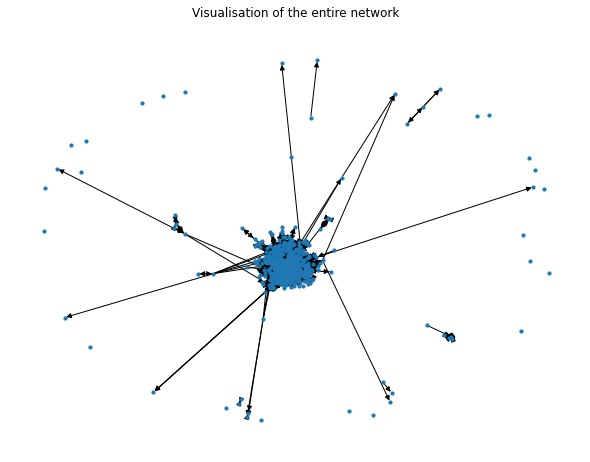

In [14]:
plt.figure(figsize=(8,6))
nx.draw(G, node_size=10)
_ = plt.title('Visualisation of the entire network')

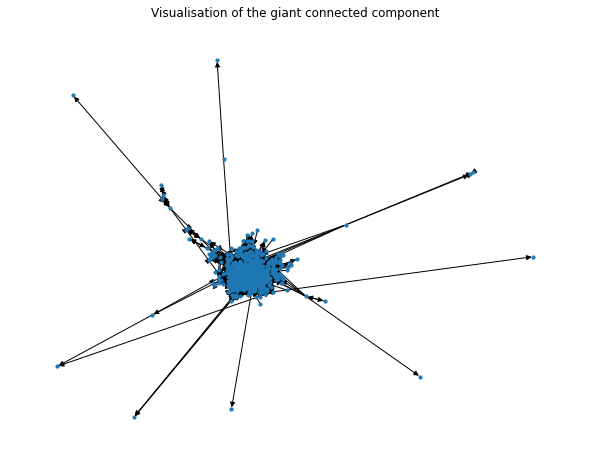

In [15]:
plt.figure(figsize=(8,6))
nx.draw(G_gc,node_size=10)
_ = plt.title('Visualisation of the giant connected component')

In [16]:
print('Giant Connected Component')
print('Number of nodes: ', G_gc.number_of_nodes())
print('Number of edges: ', G_gc.number_of_edges())

Giant Connected Component
Number of nodes:  548
Number of edges:  6771


For a better visualisation of the giant connected component an undirected graph is created from the GCC and drawn using ForceAtlas. For this visualisation node colors are based on status, where deceased characters are colored red and others are blue. Node sizes are based on the character's number of connections.

In [17]:
#Creating undirected graph using the giant connected component
UG_gc = G_gc.to_undirected()
degree_list=list(UG_gc.degree())
nodes, degree = map(list, zip(*degree_list))

In [18]:
#Getting node status and assigning each status a color
status = nx.get_node_attributes(UG_gc,'status')
color_status = {'Alive': [47/256,120/256,205/256], 'Deceased': [234/256,89/256,75/256], 'Dead': [234/256,89/256,75/256], 'Uncertain': [47/256,120/256,205/256]}

#Creating color- and sizemap for nodes before plotting the network
colormap = []
sizemap = []
for node in UG_gc.nodes():
    colormap.append(color_status[status[node][0]])
    sizemap.append(UG_gc.degree(node)*5 + 1)

100%|██████████| 2000/2000 [00:01<00:00, 1809.49it/s]


BarnesHut Approximation  took  0.20  seconds
Repulsion forces  took  0.72  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


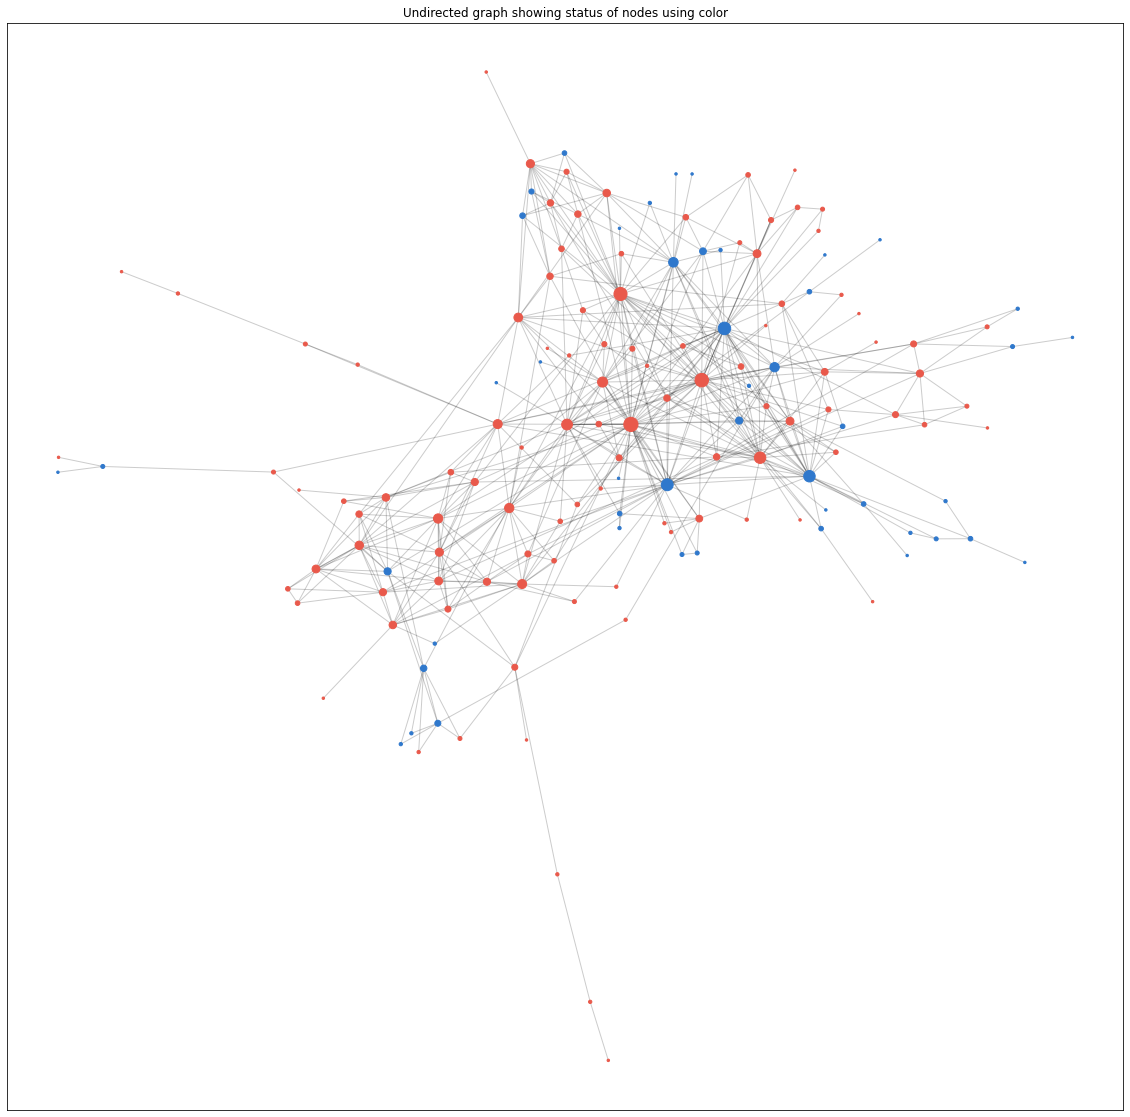

In [23]:
#Plotting network using ForceAtlas
plt.figure(figsize=(20,20))
forceatlas2 = ForceAtlas2(edgeWeightInfluence=1, scalingRatio=2)
positions = forceatlas2.forceatlas2_networkx_layout(UG_gc,pos=None,iterations=2000)
nx.draw_networkx_nodes(UG_gc,
                       positions,
                       node_color=colormap,
                       node_size=sizemap)
nx.draw_networkx_edges(UG_gc,positions,edge_color="black",alpha=0.2)
_ = plt.title('Undirected graph showing status of nodes using color')

## Word Clouds

It was decided to use word clouds for each one of the great houses as a part of the network analysis. This part of the report will go over how these word clouds were created.

First things first was to create a list called `houses_list` to store every allegiance that appears in the network. Then a list of `houses` was created from the `houses_list` by including only allegiances which relate to a households. The `houses` list was then used to create a dictionary where the keys are the unique houses and the values for each key is an array of words.

In [24]:
#Getting a list of all available allegiances
houses_list = []
for node in G_gc.nodes:
    for allegiance in G_gc.nodes[node]['allegiance']:
        houses_list.append(allegiance)
#Removing duplicates
houses_list = list(set(houses_list))

#Only include allegiances which are a House
houses = []
for h in houses_list:
    if 'House' in h:
        houses.append(h)
        
#Creating a dictionary of the houses
houses_dict = {}
for h in list(set(houses)):
    houses_dict[h] = []

In [25]:
#Creating a list of stopwords and the pattern used to extract headers
stops = list(set(stopwords.words("english")))
header_pattern = '==+ *.*? *==+'
#The lemmatizer used
wnl = nltk.WordNetLemmatizer()

Next was to loop through each character page to extract all the words the page contained. Headers were removed using the `header_pattern` as well as all character names by looping through all the nodes in the network. The text was tokenized using the `WordPunctTokenizer` and all relevant tokens were saved in the word arrays for corresponding house keys in the `houses_dict` dictionary. 

**RegEx explanation:**
Two regex patterns were used when excluding character names from the text pages.
* **name_pattern1/name_pattern2**: `(*character name*)(?:[^a-zA-Z])` this pattern was used to avoid cases where a character name was a substring in another word and the word would therefore be broken up. (i.e a character named Lann would make the word Lannister turn into ister). This pattern matches a character name that is then followed by a non-alphabetic letter. The pattern is used in a re.sub where the match is removed. 

In [26]:
#Looping through each character page
for node in G_gc.nodes:
    name = node.replace(' ','_')
    with open('./GoT_characters/'+name+'.txt') as f:
        text = f.read()
        f.close() 
    
    #Filtering out the headers of sections
    new_text = re.sub(header_pattern,'',text)

    #Excluding character names
    for n in G_gc.nodes:
        #Excluding possesive versions of the name (i.e. Arya's)
        n_poss = n+"'s"
        #Removing only where name is not a substring in another word
        name_pattern1 = '('+n+')(?:[^a-zA-Z])'
        new_text = re.sub(name_pattern1,'',new_text)
        new_text = re.sub(n_poss,'',new_text)
        #Splitting name in order to remove characters' first names
        name_list = n.split(' ')
        name_pattern2 = '('+name_list[0]+')(?:[^a-zA-Z])'
        new_text = re.sub(name_pattern2,'',new_text)

    #Tokenizing the text with WordPunctTokenizer()
    tokens = []
    tokens = WordPunctTokenizer().tokenize(new_text)

    #For each token, only include if it's not punctuation, if it's not a stopword and if it is longer than one letter when lemmatized
    #Saving results in the corresponding house array in dictionary, results are saved in lowercase and lemmatized.
    for token in tokens:
        if token.isalpha() and token.lower() not in str(stops).lower():
            for a in G_gc.nodes[node]['allegiance']:
                if 'House' in a:
                    houses_dict[a].append(wnl.lemmatize(token.lower()))
                

Now that the dictionary `houses_df` stores a list of every word in the character pages for each character in each house the next step is to count the occurences of these words. To do that a dataframe is created called `house_df` that will be used to store each individual word that occurs in the text for each house, how many times it is repeated by characters that belong to the house, and to which house it belongs. A double for loop is used to do this, looping through the keys in `house_dict` and looping through the unique words in the word list for that key. The occurence of each unique word is then counted for that house and stored in the dataframe. **Warning: this cell takes a long time to run!**

In [ ]:
#Creating a dataframe to store information about word count for each word in each house
house_df = pd.DataFrame({'word':[],'count':[],'house':[]})

#Looping through houses and words to count occurences of each word
for key in houses_dict:
    for w in list(set(houses_dict[key])):
        new_row = {'word':w, 'count':houses_dict[key].count(w), 'house':key}
        house_df = house_df.append(new_row, ignore_index=True)

Next up is calculating the tc-idf value of each word. This is done by looping through each word in the dataframe that appears in a character page for one of the top houses. The number of documents this word appears in is stored in a new dataframe column called `idf`. The `tc-idf` is then calculated by multiplying the `count` and `idf` column values for each row. **Warning: this cell takes a long time to run!**

In [ ]:
#Total number of races
n = len(list(set(houses))) 
#List of the top houses which will be the houses used to create word clouds
top_houses = ['House Stark','House Lannister','House Targaryen','House Bolton',"House Baratheon of King's Landing",'House Tyrell','House Arryn','House Tully','House Martell','Dothraki']

#Looping through each word in the character pages of the top houses to calculate the tc-idf values
for w in house_df.loc[house_df['house'].isin(top_houses) == True, 'word']:
    doc_nums = house_df.loc[house_df.word == w,'word'].count()
    house_df.loc[house_df.word == w, 'idf'] = math.log10(n/doc_nums)
house_df['tc-idf'] = house_df['count'] * house_df['idf']

Now the rounded up tc-idf value of each word for every house are stored in an array and that array is used to draw the word cloud for each house. A mask was used for the word clouds that make the clouds take a form associated to the house crest.

In [ ]:
#Declare arrays used to draw word clouds
wc_stark = []
wc_lannister = []
wc_targaryen = []
wc_bolton = []
wc_baratheon = []
wc_tyrell = []
wc_arryn = []
wc_tully = []
wc_martell = []

#Store rounded up tc-idf values in the word cloud arrays
for index, row in house_df.iterrows():
    if row['house'] == 'House Stark':
        wc_stark += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Lannister':
        wc_lannister += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Targaryen':
        wc_targaryen += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Bolton':
        wc_bolton += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == "House Baratheon of King's Landing":
        wc_baratheon += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Tyrell':
        wc_tyrell += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Arryn':
        wc_arryn += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == 'House Tully':
        wc_tully += [row['word']]*math.ceil(row['tc-idf'])
    elif row['house'] == "House Martell":
        wc_martell += [row['word']]*math.ceil(row['tc-idf'])

In [ ]:
#A list of the word cloud arrays for the houses, the wc_names relate to the names of the cloud mask figures used
wcs = [wc_stark,wc_lannister,wc_targaryen,wc_bolton,wc_baratheon,wc_tyrell,wc_arryn,wc_tully,wc_martell]
wc_names = ['wc_stark','wc_lannister','wc_targaryen','wc_bolton','wc_baratheon','wc_tyrell','wc_arryn','wc_tully','wc_martell']

#Loop through each house and draw the word cloud
for i in range(len(wcs)):
    #Declare the cloud mask used, different one for each house
    cloud_mask = imageio.imread(wc_names[i]+'.jpg')
    wordcloud = WordCloud(
                          background_color='WHITE',
                          mask = cloud_mask,
                          contour_width=1, contour_color='black',
                          collocations=False
                         ).generate(' '.join(map(str,wcs[i])))

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud)
    plt.title(top_houses[i]+' word cloud',fontsize=15)
    plt.axis('off')
    #Save word cloud as a figure
    plt.savefig(wc_names[i]+'.png')
    plt.show()

## Sentiment

Sentiment was the second network analysis that was decided to do. Both LabMT and Vader were used to calculate the sentiment of each character as well as the overall sentiment of each one of the great houses. This part of the report will explain how the sentiment was calculated using these two methods.

The first thing was to define a function that cleans the character page text and returns the individual cleaned sentences from each page.

*  `(?:== *Biography *==)(.*?)(?:== *See also *==)` was used to leave out the table at the top, since most of the useful text starts with the header Biography and ends with See also. 
*  `(?:== *(.*?)*==)` removes all the headers in the text.
*  `\[\[File:(.*?)\]\]` removes all the files in the text, mostly removing all the images.
*  Some of the link are in the following format [[text1|text]], for those instances the first bracket was removed as well as text1, and text2 only left behind, for that the following reggex was used:  `\[\[[\(\)\'a-zA-Z\s\d]*\|`. After many different symbols were removed as well, which removed the closing bracket.
* `\\\\n` removed the line breaks in the text.
* Some of the links were in the following format <ref> Link </ref>, therefore the following reggex was used to remove those links `<ref(.*?)>(.*?)</ref`.
* Finally all the text was split using the delimiter . to split each sentence up.

In [19]:
#Function used to clean the character page text and extracting sentences.
def clean_text(text):
    pattern = "(?:== *Biography *==)(.*?)(?:== *See also *==)"
    text = re.findall(pattern, text)
    pattern = "(?:== *(.*?)*==)"
    text = re.sub(pattern,'',text[0]) 
    pattern = '\[\[File:(.*?)\]\]'
    text = re.sub(pattern, '',text)
    pattern = "\[\[[\(\)\'a-zA-Z\s\d]*\|"
    text = re.sub(pattern, '',text)
    text = text.replace('[[','')
    text = text.replace(']]','')
    text = text.replace('{{','')
    text = text.replace('}}','')
    text = text.replace('=','')
    pattern = '\\\\n'
    text = re.sub(pattern, '', text)
    pattern = '<ref(.*?)>(.*?)</ref>'
    text = re.sub(pattern, '', text)
    text = text.replace('|','')
    text = text.split('.')
    return text

In [20]:
#Cleaning character pages using the clean_text function. 
#Saving the array of sentences in a dataframe called data where the keys are the characters.
data = {}
for node in UG_gc.nodes:
    name = node.replace(' ','_')
    with open('./GoT_characters/'+name+'.txt') as f:
        text = f.read()
        f.close() 
    text = clean_text(text)
    data.update({node: text})

### LabMT

When using the LabMT sentiment analysis, words from the file LabMT.csv are used, all the words from the file were read and saved in a list called LabMT_list.

In [21]:
#LabMT file opened and saved in a list
file = open('./LabMT.csv')
csvreader = csv.reader(file)
LabMT_list = []
for row in csvreader:
    LabMT_list.append(row)
LabMT_list=LabMT_list[1:]

A function was created takes in the wordlist that needs to be analysed, as well as the LabMT_list

In [22]:
#Function that calculates the senitment
def calc_sent(words_list, sentiment_list):
    sent_score = []
    for word in words_list:
        for sentiment in sentiment_list:
            if sentiment[0] == word:
                sent_score.append(float(sentiment[2]))
    return np.mean(sent_score)

In [23]:
#More cleaning done for the sentences in the dictionary created earlier
for key, value in data.items():
    for i, sentence in enumerate(value):
        value[i] = re.sub("[^a-zA-Z0-9, \ , \']+", "", sentence)

LabMT calculates its sentiment using tokens from the sentences, therefore each sentence needs to be tokenized.

In [24]:
wnl = nltk.WordNetLemmatizer()
LabMT = []
#All the characters read from the dictionary and saved in a list
char = list(data.keys())

#Going throug each character in the dictionary
for node in char:
    word = data[node]
    tokens = []
    tokenizer = []
    #Tokenizing each word
    for w in word:
        token = WordPunctTokenizer().tokenize(w)
        tokens = tokens + token

    final_tokens = []
    #Lemmatizing each token and putting to lower case
    for token in tokens:
        final_tokens.append(wnl.lemmatize(token.lower()))

    #Calculating average score for each node using the LabMT wordlist and adding as an attribute
    char_sent_score = calc_sent(final_tokens, LabMT_list)
    LabMT.append(char_sent_score)
    UG_gc.nodes[node]['LabMT'] = char_sent_score

#### LabMT visualization

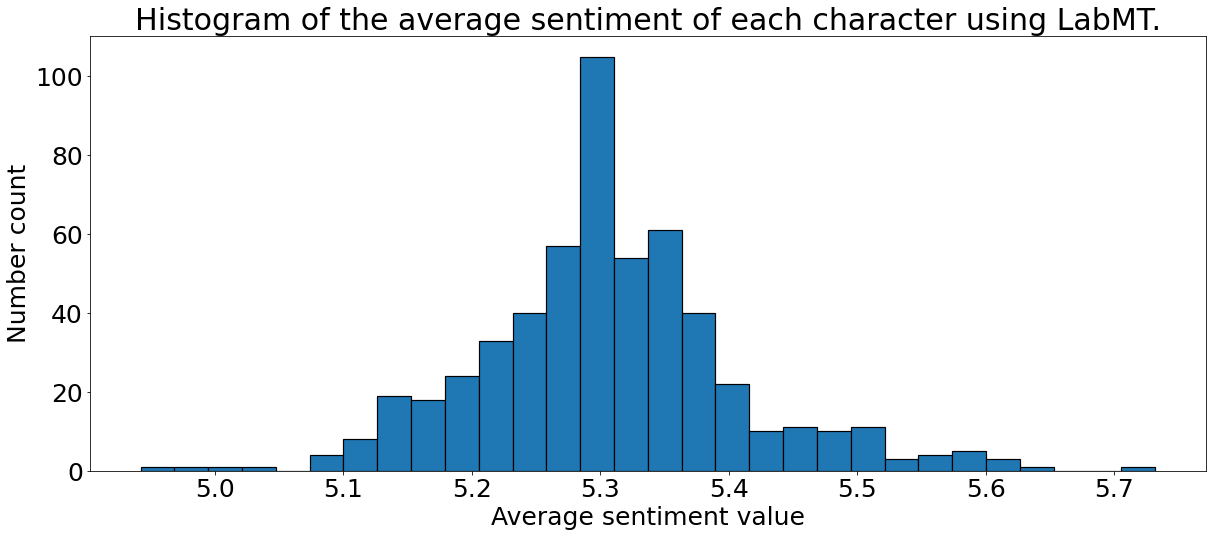

In [25]:
plt.figure(figsize = (20,8))
plt.hist(LabMT, bins = 30, edgecolor='black', linewidth=1.2)
plt.show
plt.ylabel('Number count',fontsize=25)
plt.xlabel('Average sentiment value',fontsize=25)
plt.xticks(fontsize=25)
plt.title('Histogram of the average sentiment of each character using LabMT.',fontsize=30)
_ = plt.yticks(fontsize=25)
plt.savefig('Sentiment_LabMT.png')

In [26]:
all_LabMT = []
for node in char:
    all_LabMT.append([node, UG_gc.nodes[node]['LabMT']])
        
happiest_char = sorted(all_LabMT, key = lambda i: i[1], reverse=True)[0:10]
saddest_char = sorted(all_LabMT, key = lambda i: i[1], reverse=False)[0:10]
print("The happiest characters are: ",[x[0] for x in happiest_char])
print("The saddest characters are: ",[x[0] for x in saddest_char])

The happiest characters are:  ['Maron Martell', 'Dorna Lannister', 'Alys Arryn', 'Lomas Longstrider', 'Myriah Martell', 'Ryger Rivers', 'Serra Frey', 'Minisa Tully', 'Sarra Frey', 'Theomar Smallwood']
The saddest characters are:  ['Garrison Fowler', 'Burton Crakehall', 'Gwayne Gaunt', 'Harlan Hoare', 'Joffrey Dayne', 'Raymun Darry', 'Meria Martell', 'Imry Florent', 'Johanna Lannister', 'Albin Manwoody']


### Vader

Vader uses the whole sentence for the analysis but not only the tokens like LabMT. A function was created as well for Vader where eacth sentence is analyzed, the function returns a mean of the compound score for each sentence, the compound score is the negative score and the positive score combined.

In [27]:
def calc_sent_Vader(word_list):
    sent_score = []
    analyzer = SentimentIntensityAnalyzer()
    for word in word_list:
        vs = analyzer.polarity_scores(word)
        sent_score.append(vs['compound'])
    return np.mean(sent_score)         

In [28]:
Vader = []
char = list(data.keys())
#Going through all the characters
for node in char:
    word = data[node]
    #Each sentence for every character is analysed and the mean value of of the sentiment calculated
    char_sent_score = calc_sent_Vader(word)
    Vader.append(char_sent_score)
    #The sentiment is saved as an attribute for the node
    UG_gc.nodes[node]['Vader'] = char_sent_score

#### Vader visualization

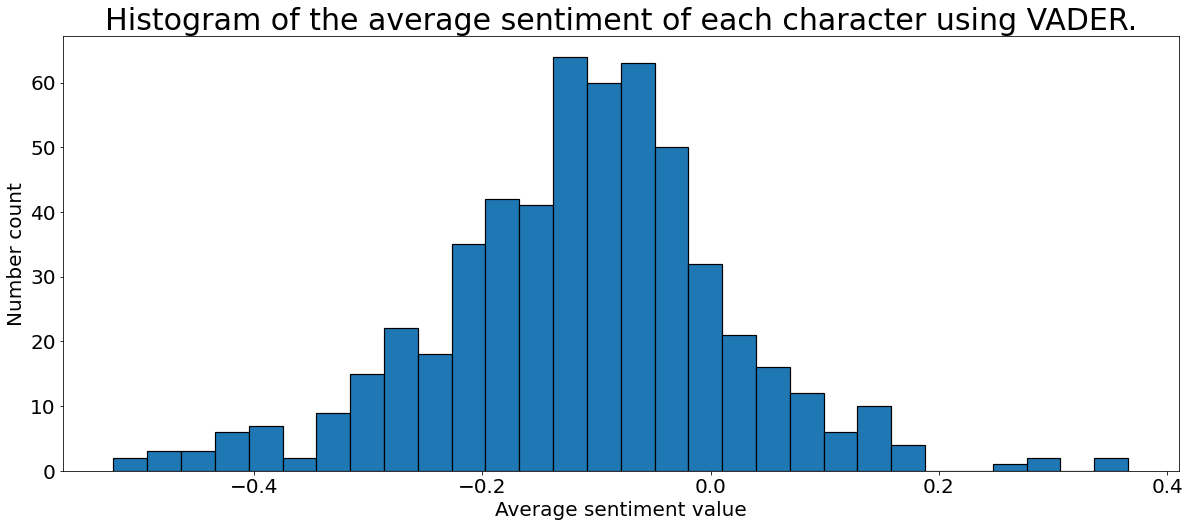

In [29]:
plt.figure(figsize = (20,8))
plt.hist(Vader, bins = 30, edgecolor='black', linewidth=1.2)
plt.show
plt.ylabel('Number count',fontsize=20)
plt.xlabel('Average sentiment value',fontsize=20)
plt.xticks(fontsize=20)
plt.title('Histogram of the average sentiment of each character using VADER.',fontsize=30)
_ = plt.yticks(fontsize=20)
plt.savefig('Sentiment_Vader.png')

In [30]:
all_Vader = []
for node in char:
    all_Vader.append([node, UG_gc.nodes[node]['Vader']])
        
happiest_char = sorted(all_Vader, key = lambda i: i[1], reverse=True)[0:10]
saddest_char = sorted(all_Vader, key = lambda i: i[1], reverse=False)[0:10]
print("The happiest characters are: ",[x[0] for x in happiest_char])
print("The saddest characters are: ",[x[0] for x in saddest_char])

The happiest characters are:  ['Richard Lonmouth', 'Qarlton Chelsted', 'Barth', 'Damon Morrigen', 'Walter Whent', 'Laena Velaryon', 'Garlan Tyrell', 'Aegon Ambrose', 'Lyle Bracken', 'Marya Seaworth']
The saddest characters are:  ['Elenei', 'Harlan Hoare', 'Garrison Fowler', 'Gwayne Gaunt', 'Torrhen Karstark', 'Qyle Corbray', 'Gelmarr', 'Hugh Hammer', 'Aggar', 'Haegon Blackfyre']


### Sentiment of the great houses

The sentiment was as well calculated for each of the Houses, that means that the average sentiment was calculated for each character that pledged allegiance to that House.

In [31]:
top_houses = ['House Stark','House Lannister','House Targaryen','House Bolton',"House Baratheon of King's Landing",'House Tyrell','House Arryn','House Tully','House Martell']
top_houses_names = ['Stark','Lannister','Targaryen','Bolton',"Baratheon",'Tyrell','Arryn','Tully','Martell']
LabMT_sent = np.zeros(len(top_houses))
LabMT_sent_std = np.zeros(len(top_houses))
char = list(data.keys())
LabMT_names = ['' for i in range(0, len(top_houses))]
#Iterating through each house
for i in range(0,len(top_houses)):
    temp_com = []
    #Iterating through every character and summing up their allegiance
    for node in char: 
        if top_houses[i] in UG_gc.nodes[node]['allegiance']:
            #Sentiments for characters with that allegiance saved in a list
            temp_com.append(UG_gc.nodes[node]['LabMT'])
    if temp_com == []:
        mean_temp_com = 0
    else:
        #The mean of the sentiment for each character calculated
        mean_temp_com = np.mean(temp_com)
    #The mean sentiment for each House saved in LabMT_sent
    LabMT_sent[i] = mean_temp_com
    LabMT_sent_std[i] = np.std(temp_com)

In [32]:
Vader_sent = np.zeros(len(top_houses))
Vader_sent_std = np.zeros(len(top_houses))
char = list(data.keys())
Vader_names = ['' for i in range(0, len(top_houses))]

#Iterating through each house
for i in range(0,len(top_houses)):
    temp_com = []
    for node in char:
        if top_houses[i] in UG_gc.nodes[node]['allegiance']:
            #Sentiments for characters with that allegiance saved in a list
            temp_com.append(UG_gc.nodes[node]['Vader'])
    if temp_com == []:
        mean_temp_com = 0
    else:
        #The mean of the sentiment for each character calculated
        mean_temp_com = np.mean(temp_com)
    #The mean sentiment for each House saved in Vader_sent
    Vader_sent[i] = mean_temp_com
    Vader_sent_std[i] = np.std(temp_com)

In [33]:
highest_LabMT = sorted(LabMT_sent, reverse=True)[0:3]
highest_vader = sorted(Vader_sent, reverse=True)[0:3]

LabMT_sent = list(LabMT_sent)

com1 = LabMT_sent.index(highest_LabMT[0])
com2 = LabMT_sent.index(highest_LabMT[1])
com3 = LabMT_sent.index(highest_LabMT[2])

print('Three happiest houses according to LabMT are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Vader_sent = list(Vader_sent)

com1 = Vader_sent.index(highest_vader[0])
com2 = Vader_sent.index(highest_vader[1])
com3 = Vader_sent.index(highest_vader[2])

print('Three happiest houses according to Vader are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Three happiest houses according to LabMT are:
House Martell
House Tyrell
House Tully
Three happiest houses according to Vader are:
House Tyrell
House Tully
House Baratheon of King's Landing


In [34]:
lowest_LabMT = sorted(LabMT_sent, reverse=False)[0:3]
lowest_Vader = sorted(Vader_sent, reverse=False)[0:3]

LabMT_sent = list(LabMT_sent)

com1 = LabMT_sent.index(lowest_LabMT[0])
com2 = LabMT_sent.index(lowest_LabMT[1])
com3 = LabMT_sent.index(lowest_LabMT[2])

print('Three saddest houses according to LabMT are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Vader_sent = list(Vader_sent)

com1 = Vader_sent.index(lowest_Vader[0])
com2 = Vader_sent.index(lowest_Vader[1])
com3 = Vader_sent.index(lowest_Vader[2])

print('Three saddest houses according to Vader are:')
print(top_houses[com1])
print(top_houses[com2])
print(top_houses[com3])

Three saddest houses according to LabMT are:
House Lannister
House Stark
House Bolton
Three saddest houses according to Vader are:
House Lannister
House Bolton
House Martell


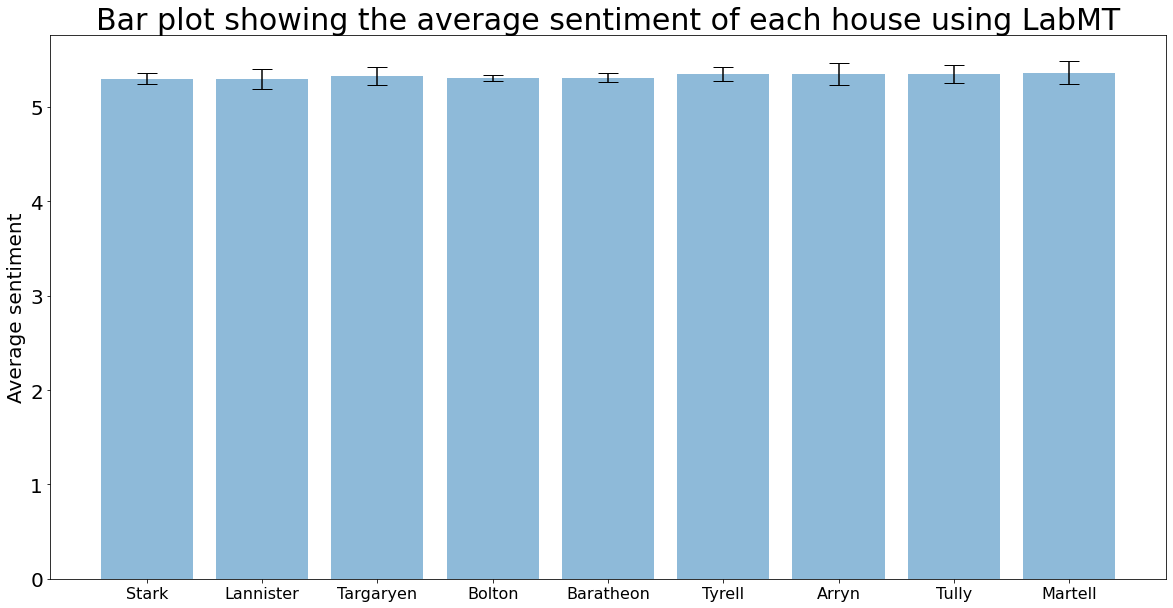

In [35]:
plt.figure(figsize = (20,10))
plt.bar(top_houses, LabMT_sent ,yerr = LabMT_sent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(top_houses, top_houses_names, fontsize=16, rotation = 0)
plt.yticks(fontsize=20)
plt.ylabel('Average sentiment',fontsize=20)
_ = plt.title('Bar plot showing the average sentiment of each house using LabMT', fontsize=30)
plt.savefig('Sentiment_LabMT_houses.png')

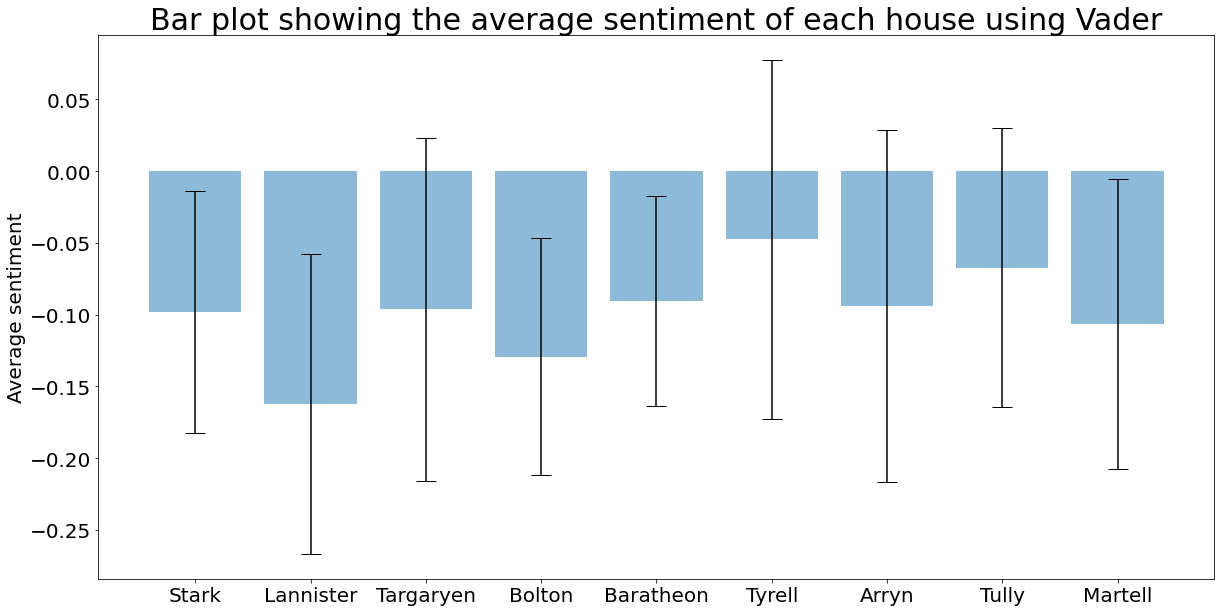

In [36]:
plt.figure(figsize = (20,10))
plt.bar(top_houses, Vader_sent ,yerr = Vader_sent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(top_houses, top_houses_names, fontsize=20, rotation = 0)
plt.yticks(fontsize=20)
plt.ylabel('Average sentiment',fontsize=20)
_ = plt.title('Bar plot showing the average sentiment of each house using Vader', fontsize = 30)
plt.savefig('Sentiment_Vader_houses.png')

## Who has the most blood on their hands

Next was the analysis of which character killed the most in total, as well as for each House. For each house the death attribute was analysed, which contains the name of the person that killed the owner of the node. For each house a graph was made of the deaceased characters with known killers, and the color of the node corresponds to their killer. A table was also made showing which color belongs to which killer, as well as how many they killed in that house.

In [102]:
#Getting every death attribute (every person that has killed someone)
death = nx.get_node_attributes(UG_gc,'death')
death_set = set()
death_all = []
#Making a list that only has the unique values of deaths (every person comes up once)
for val in death.values():
    death_set.add(val[0])
    death_all.append(val[0])
death_set = list(death_set)

#Counting how many occurances there are of that death instance (counting how many that person killed)
death_count = {}
for d in death_set:
    death_count.update({d: death_all.count(d)})

For each house a subgraph was created only containing the deceased characters in that particular House

In [103]:
top_houses = ['House Stark','House Lannister','House Targaryen','House Bolton',"House Baratheon of King's Landing",'House Tyrell','House Arryn','House Tully','House Martell']
nodes_houses = [[] for i in range(0,len(top_houses))]

#Iterating through every node
for node in UG_gc.nodes():
    #Only using those that are dead
    if (UG_gc.nodes[node]['status'][0] == 'Deceased') | (UG_gc.nodes[node]['status'][0] == 'Dead'):
        #Leaving out those that have unknown death for better visualization
        if UG_gc.nodes[node]['death'][0] != 'Unknown':
            if 'House Stark' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[0].append(node)
            if 'House Lannister' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[1].append(node)
            if 'House Targaryen' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[2].append(node)   
            if 'House Bolton' in UG_gc.nodes[node]['allegiance']:
                nodes_houses[3].append(node)
            if  "House Baratheon of King's Landing" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[4].append(node)
            if  "House Tyrell" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[5].append(node)
            if  "House Arryn" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[6].append(node)
            if  "House Tully" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[7].append(node)
            if  "House Martell" in UG_gc.nodes[node]['allegiance']:
                nodes_houses[8].append(node)

#Creating a subgraph with only the nodes of deceased and with known deaths for each house 
UG_house = [[] for i in range(0,len(top_houses))]
counter=0
for node in nodes_houses:
    s_graph = UG_gc.subgraph(node)
    UG_house[counter] = s_graph.copy()
    counter=counter+1

In [105]:
#Function that creates a random color
def random_color():
    rand_nr1 = random.randrange(0,100,1)/100
    rand_nr2 = random.randrange(0,100,1)/100
    rand_nr3 = random.randrange(0,100,1)/100
    return (rand_nr1, rand_nr2, rand_nr3)

#Function that chooses a random color for the death attribute(person), and counts how many instances there are of each input death attributes
def death_count_attribute(death):
    #Making a list that only has the unique values of deaths (every person comes up once)
    death_set = set()
    death_all = []
    for val in death.values():
        death_set.add(val[0])
        death_all.append(val[0])
    death_set = list(death_set)
    color_death = {}
    #Choosing a random color for each death 
    for i in range(0,len(death_set)):
        color = random_color()
        color_death.update({death_set[i]: color})
    #Counting how many occurances there are of that death instance (counting how many that person killed)
    death_count = {}
    for d in death_set:
        death_count.update({d: death_all.count(d)})
    return color_death, death_count

In [106]:
death = [[] for i in range(0,len(top_houses))]
color_death_house = [[] for i in range(0,len(top_houses))]
color_death_count = [[] for i in range(0,len(top_houses))]
counter = 0
for subgraph in UG_house:
    #Getting every death attribute (every person that has killed someone) in each subgraph
    death[counter] = nx.get_node_attributes(subgraph,'death')
    #Setting a color for each person, and counting how many they have kill
    color_death_house[counter], death_count_house[counter] = death_count_attribute(death[counter])
    counter = counter + 1

In [114]:
#Making a colormap for the graph for each house
counter=0
colormap_house = [[] for i in range(0,len(top_houses))]
for house in UG_house:
    for node in house.nodes():
        colormap_house[counter].append(color_death_house[counter][death[counter][node][0]])
    counter = counter+1



In [117]:
#Function that plots a table where the color is shown for each person and how many they have killed
def plot_colortable(colors, title, sort_colors=True, emptycols=0, count=0):
    cell_width = 412
    cell_height = 40
    swatch_width = 48
    margin = 12
    topmargin = 40


    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        name_count = name + ": " + str(count[name])
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7
        ax.text(text_pos_x, y, name_count, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )
    return fig


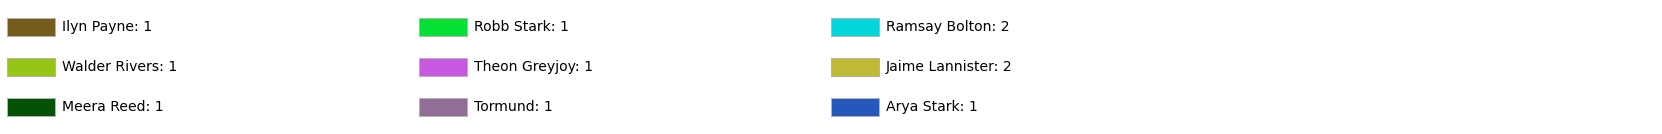

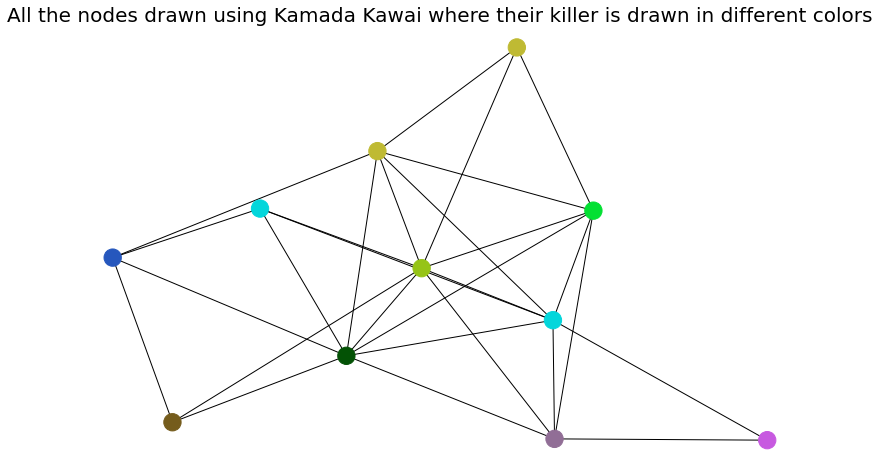

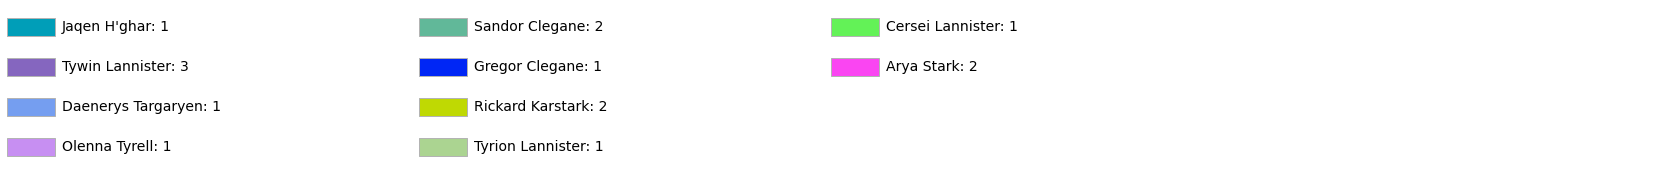

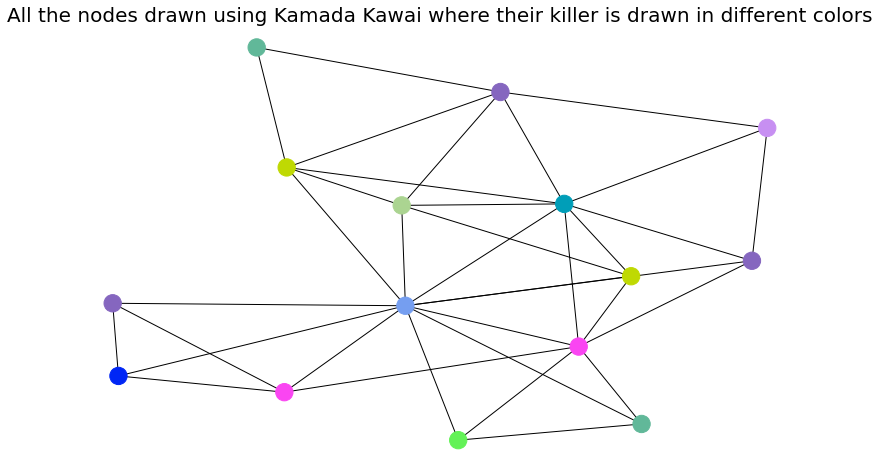

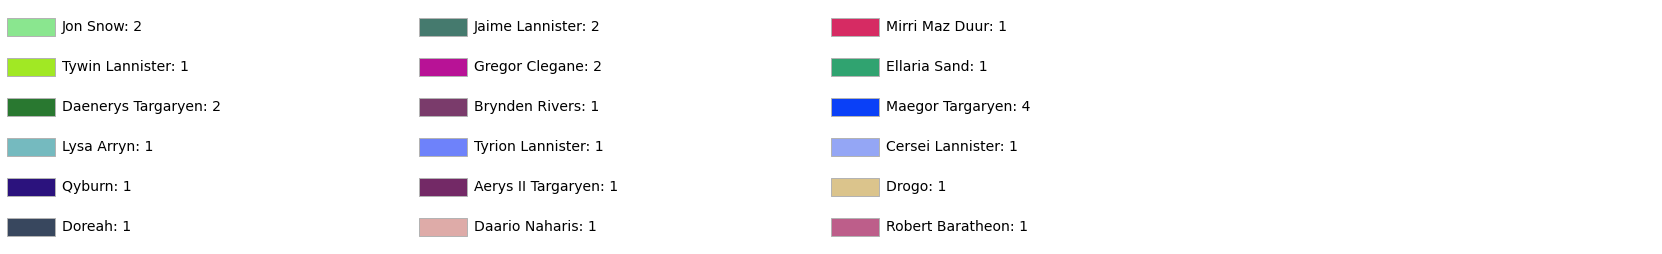

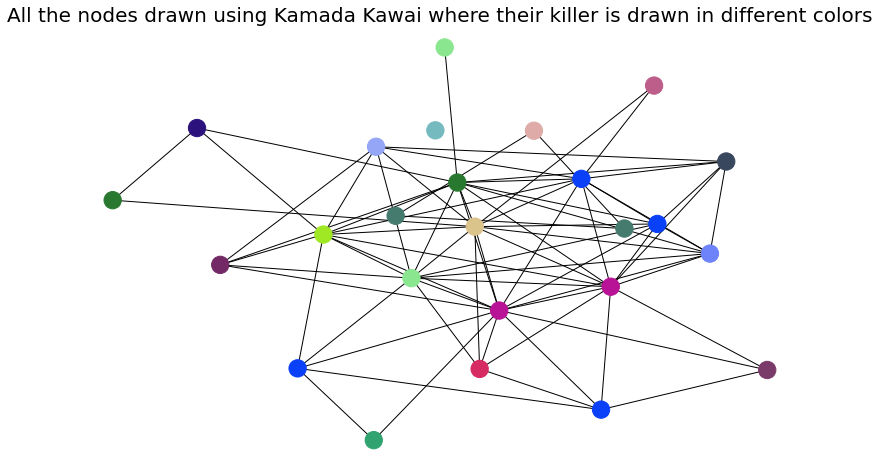

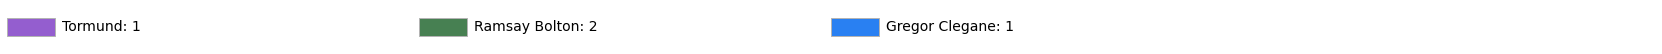

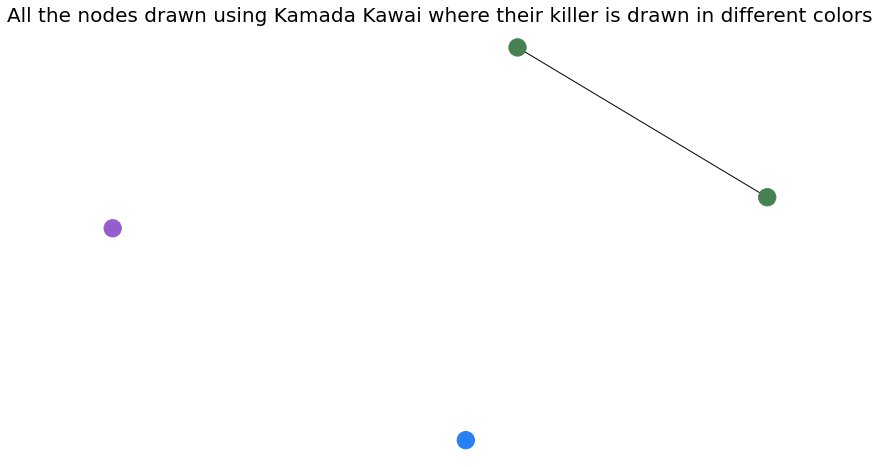

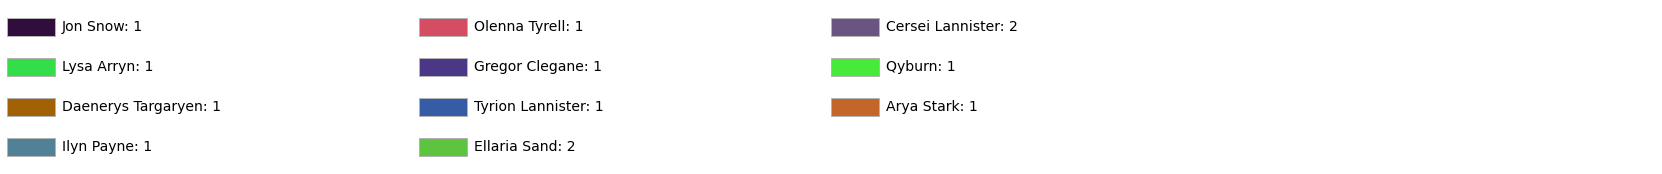

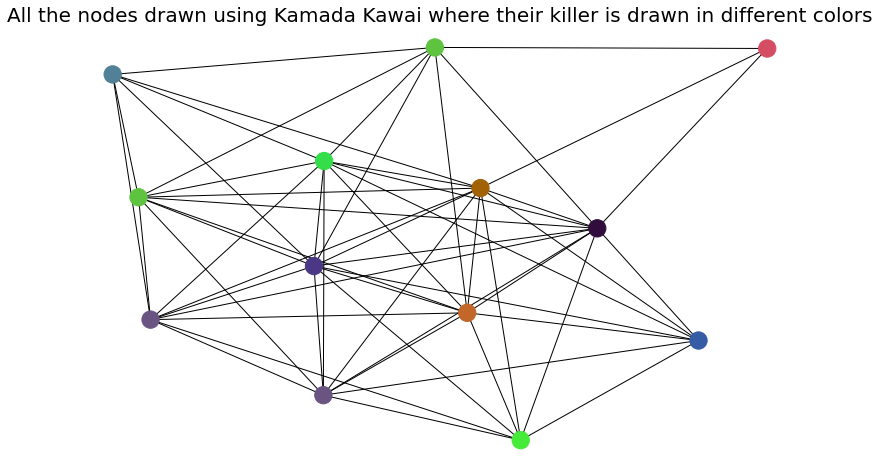

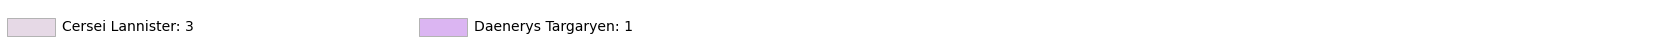

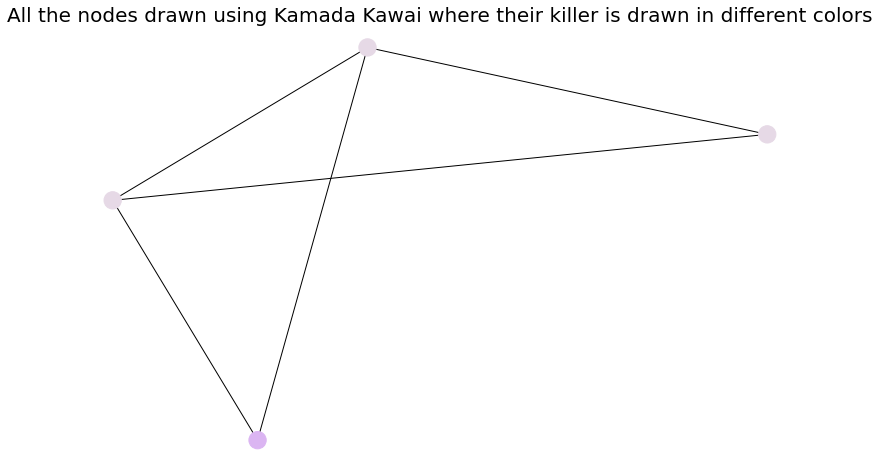

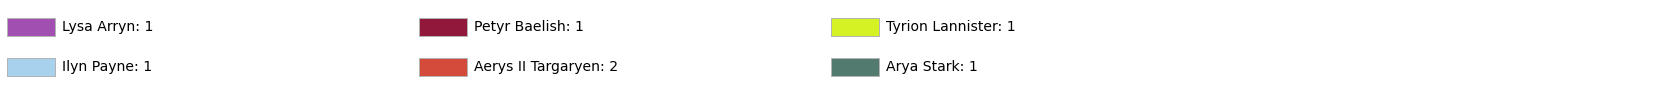

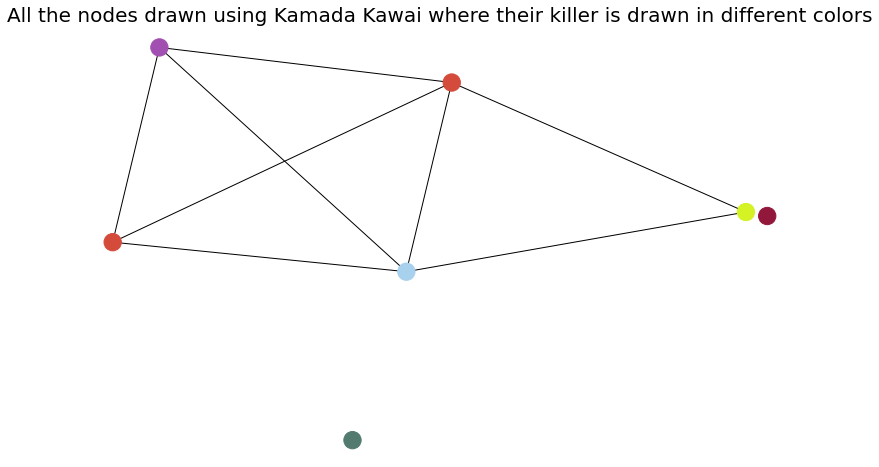

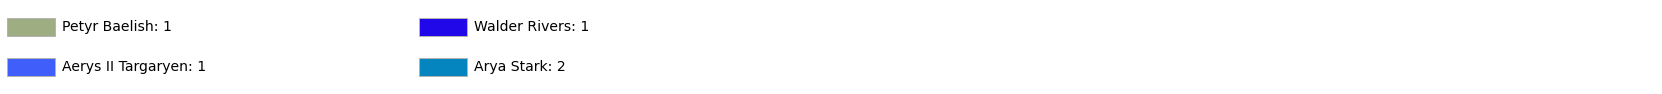

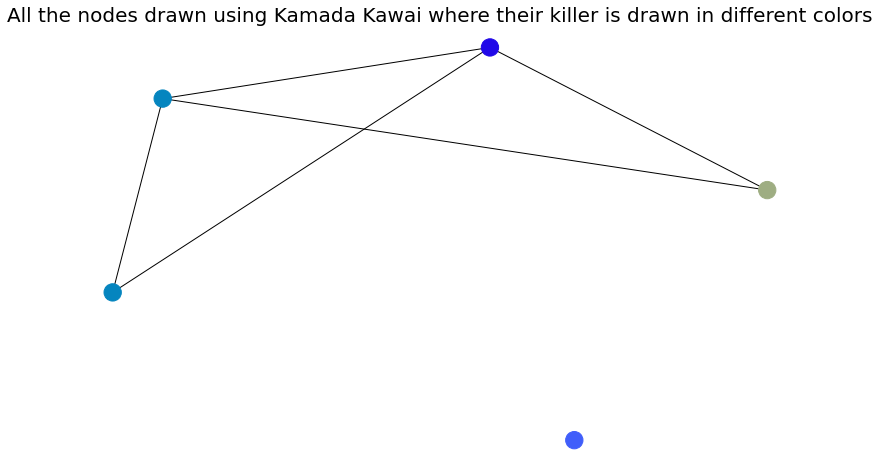

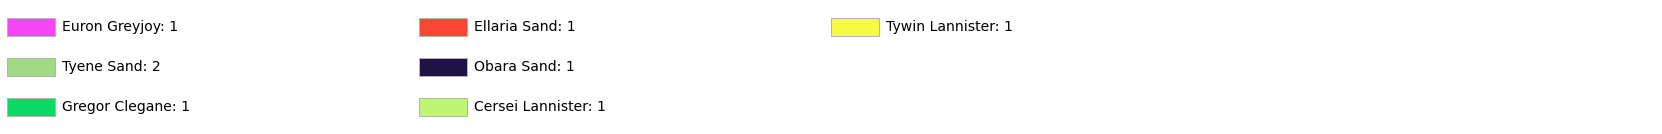

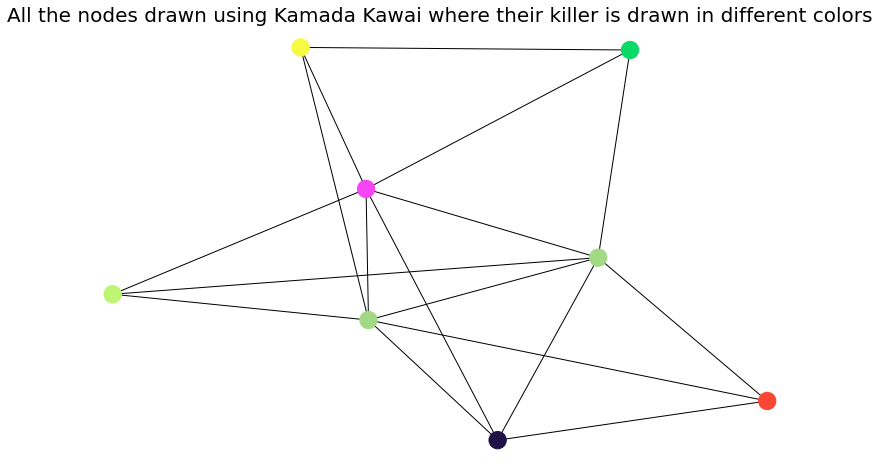

In [118]:
house_name = ['Stark', 'Lann', 'Targ', 'Bolton', 'Baratheon','Tyrell','Arryn','Tully','Martell']
#Iterrating through each house
for i in range(len(house_name)):
    #Creating a table with all the names of the killers and their color in the graph
    plot_colortable(color_death_house[i], "", sort_colors=False, emptycols=1, count = death_count_house[i])
    plt.savefig('Death_Colortable_'+house_name[i]+'.png')

    plt.show()
    #Creating a graph where each color corresponds to the killer of the owner of the node
    plt.figure(figsize=(10,6))
    nx.draw_kamada_kawai(
        UG_house[i], 
        nodelist=nodes_houses[i], 
        node_color=colormap_house[i]
    )
    _ = plt.title('All the nodes drawn using Kamada Kawai where their killer is drawn in different colors',fontsize=20)
    plt.savefig('Death_Plot_'+house_name[i]+'.png')

## Family Trees

The final network analysis was creating family trees for each one of the great houses. This analysis was done using a program called [Gramps](https://gramps-project.org/blog/). When downloading the program, a `.py` file is downloaded called `familytreemaker.py`. To create the tree, the program is run using a `.txt` file containing information on the family in a very specific format as a parameter. Along with the `.txt` file, the name of the person used as the "head of the family" and the name of the output `.dot` file are included as parameters. Some changes were made to the `familytreemaker.py` file in order to make it work correctly for the great houses in this network.

To start, the input file `Family_Tree.txt` was created. This file needed to be in a specific format in order for it to work correctly with the program. Spouses should be in adjacent lines, followed by their children which were indented. Empty lines are used to distinguish between families. The program did not accept single parents, i.e one parent followed by children. Therefore, "bastard" children, i.e children who did not have two parents that were each others spouse, were added to the tree with an "Unknown spouse of ..." as the missing parent.

In [ ]:
file_name = 'Family_Tree.txt'
#The names variable helps keep count of characters which have not yet been added to the file
names = list(UG_gc.nodes).copy()

#Looping through all characters in the giant component
for node in UG_gc.nodes:
    #All of the character's children are added to the bastards list, will be removed if the other parent is found
    bastards = UG_gc.nodes[node]['children'].copy()
    if 'Unknown' in bastards:
        bastards.remove('Unknown')
    text_file = open(file_name, "a")
    
    #Only add character if it has not been added before
    if node in names:
        if UG_gc.nodes[node]['spouse'] != ['Unknown']:
            
            #Adding all spouses to a list and looping through each one
            spouses = UG_gc.nodes[node]['spouse']
            for spouse in spouses:
                #Write name of character and it's spouse to the file
                text_file.write(node + '\n')
                text_file.write(spouse + '\n')
                if spouse in names:
                    names.remove(spouse)
    
                #Looping through each of the character's children
                for child in UG_gc.nodes[node]['children']:
                    #If the spouse is not in the character list, write the children under that spouse
                    if spouse not in UG_gc.nodes():
                        if child != 'Unknown':
                            text_file.write('\t' + child + '\n')
                            if child in bastards:
                                bastards.remove(child)
                    #If the spouse is in the character list
                    #only write the children under this spouse if the child is in the spouses children list 
                    elif child in UG_gc.nodes[spouse]['children'] and child != 'Unknown':
                        text_file.write('\t' + child + '\n')
                        if child in bastards:
                                bastards.remove(child)

                text_file.write('\n') 
        
        #Add bastards under undknown spouse of node
        if bastards:
            text_file.write(node + '\n')
            text_file.write('Unknown spouse of ' + node + '\n')
            for child in bastards:
                text_file.write('\t' + child + '\n')

            text_file.write('\n')
        
    text_file.close()

Running the `familytreemaker.py` program for each family. The outputting `.dot` file is then used to draw the family tree using graphviz. The resulting family trees will be included in the turn-in directory. They can also be seen on the website.

In [ ]:
%run ./familytreemaker.py -a 'Tytos Lannister' Family_Tree.txt -o 'Family_Tree_Lannister.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Lannister.dot -o Family_Tree_Lannister.png

In [ ]:
%run ./familytreemaker.py -a 'Rickard Stark' Family_Tree.txt -o 'Family_Tree_Stark.dot' 

In [ ]:
%%bash 
dot -Tpng Family_Tree_Stark.dot -o Family_Tree_Stark.png

In [ ]:
%run ./familytreemaker.py -a 'Maekar Targaryen' Family_Tree.txt -o 'Family_Tree_Targaryen.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Targaryen.dot -o Family_Tree_Targaryen.png

In [ ]:
%run ./familytreemaker.py -a 'Roose Bolton' Family_Tree.txt -o 'Family_Tree_Bolton.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Bolton.dot -o Family_Tree_Bolton.png

In [ ]:
%run ./familytreemaker.py -a 'Steffon Baratheon' Family_Tree.txt -o 'Family_Tree_Baratheon.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Baratheon.dot -o Family_Tree_Baratheon.png

In [ ]:
%run ./familytreemaker.py -a 'Hoster Tully' Family_Tree.txt -o 'Family_Tree_Tully.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Tully.dot -o Family_Tree_Tully.png

In [ ]:
%run ./familytreemaker.py -a 'Mors Martell' Family_Tree.txt -o 'Family_Tree_Martell.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Martell.dot -o Family_Tree_Martell.png

In [ ]:
%run ./familytreemaker.py -a 'Luthor Tyrell' Family_Tree.txt -o 'Family_Tree_Tyrell.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Tyrell.dot -o Family_Tree_Tyrell.png

In [ ]:
%run ./familytreemaker.py -a 'Jasper Arryn' Family_Tree.txt -o 'Family_Tree_Arryn.dot'

In [ ]:
%%bash 
dot -Tpng Family_Tree_Arryn.dot -o Family_Tree_Arryn.png